# Exploring Word Embeddings

Adapted from [the BERT for Humanists](https://melaniewalsh.github.io/BERT-for-Humanists/) Team

How can we measure the similarity of words in a collection of texts? For example, how similar are the words "nature" and "science" in a collection of 16th-20th century English language poems? Do 20th-century poets use the word "science" differently than 16th-century poets? Can we map all the different uses and meanings of the word "nature"?

The short answer is: yes! We can explore all of these questions with word embeddings! There are two types of embeddings: **static** or type-based where each word has a single vector or embedding, and **contextualized** or token-based where each word can have multiple vectors based on its context.

## In This Notebook
In this Colab notebook, we will specifically analyze a collection of poems scraped from [Public-Domain-Poetry.com](http://public-domain-poetry.com/) with the [GLoVe](https://nlp.stanford.edu/projects/glove/) and [DistilBert model](https://huggingface.co/transformers/model_doc/distilbert.html).

## **Import necessary Python libraries and modules**

In [ ]:
# For data manipulation and analysis
import pandas as pd
pd.options.display.max_colwidth = 200
import numpy as np

Ok enough introduction! Let's get started.

To use the HuggingFace [`transformers` Python library](https://huggingface.co/transformers/installation.html), we first need to install it with `pip`.

In [ ]:
!pip install gensim

In [ ]:
!pip install transformers

In [ ]:
# For GLoVe

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

Gensim provides a convenient KeyedVectors class to work with word vectors. You'll need to download the pre-trained GloVe embeddings in advance. Download GloVe pre-trained word vectors from the GloVe website (https://nlp.stanford.edu/projects/glove/)

Here's an example using the Gensim library to load pre-trained GloVe embeddings:



In [ ]:
glove_file = datapath('/content/glove.6B.50d.txt')
word2vec_glove_file = get_tmpfile("glove.6B.50d.word2vec.txt")
glove2word2vec(glove_file, word2vec_glove_file)

<ipython-input-42-dfae7b24fe45>:3: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, word2vec_glove_file)


(400000, 50)

In [ ]:
glove_model = KeyedVectors.load_word2vec_format(word2vec_glove_file)

Uploading the model to google colab might take some time. In the meantime, while the model is being uploaded, feel free to check out the BERT embeddings.

Now, you have loaded the pre-trained GloVe word vectors using Gensim. You can use glove_model to perform various operations, such as getting the vector for a specific word or finding similar words.

In [ ]:
# Get the vector for a specific word
vector_for_word = glove_model['example']

# Find similar words to a given word
similar_words = glove_model.most_similar('example', topn=5)

# Print the results
print("Vector for 'example':", vector_for_word)
print("Similar words to 'example':", similar_words)

Vector for 'example': [ 0.51564    0.56912   -0.19759    0.0080456  0.41697    0.59502
 -0.053312  -0.83222   -0.21715    0.31045    0.09352    0.35323
  0.28151   -0.35308    0.23496    0.04429    0.017109   0.0063749
 -0.01662   -0.69576    0.019819  -0.52746   -0.14011    0.21962
  0.13692   -1.2683    -0.89416   -0.1831     0.23343   -0.058254
  3.2481    -0.48794   -0.01207   -0.81645    0.21182   -0.17837
 -0.02874    0.099358  -0.14944    0.2601     0.18919    0.15022
  0.18278    0.50052   -0.025532   0.24671    0.10596    0.13612
  0.0090427  0.39962  ]
Similar words to 'example': [('instance', 0.9669908881187439), ('particular', 0.9291923642158508), ('such', 0.9044108390808105), ('similar', 0.9010181427001953), ('same', 0.9001578092575073)]


Similarly, we will import the DistilBertModel and DistilBertTokenizerFast from the Hugging Face `transformers` library. We will also import a handful of other Python libraries and modules.

In [ ]:
# For BERT
from transformers import DistilBertTokenizerFast, DistilBertModel

# for dimensionality reduction and visualizing the embeddings
from sklearn.decomposition import PCA

# For interactive data visualization
import altair as alt

## **Load text dataset**

Our dataset contains around ~30 thousand poems scraped from  http://public-domain-poetry.com/. This website hosts a curated collection of poems that have fallen out of copyright, which makes them easier for us to share on the web.
You can find the data in our [GitHub repository](https://github.com/melaniewalsh/BERT-4-Humanists/blob/main/data/public-domain-poetry.csv).

We don't have granular date information about when each poem was published, but we do know the birth dates of most of our authors, which we've used to loosely categorize the poems by time period. The poems in our data range from the Middle Ages to the 20th Century, but most come from the 19th Century. The data features both well-known authors — William Wordsworth, Emily Elizabeth Dickinson, Paul Laurence Dunbar, Walt Whitman, Shakespeare — as well as less well-known authors.

Below we will use the Python library `pandas` to read in our CSV file of poems. It is convenient (especially for Colab notebooks) that `pandas` allows you to read in files directly from the web.

In [ ]:
url = "https://raw.githubusercontent.com/melaniewalsh/BERT-4-Humanists/main/data/public-domain-poetry.csv"

poetry_df = pd.read_csv(url, encoding='utf-8')
# Show 5 random rows
poetry_df.sample(5)

,author,title,text,lifespan,birth_year,death_year,link,period
16837,Michael Drayton,Sonnets: Idea LIX To Proverbs,"As Love and I late harboured in one inn,\r\nWith Proverbs thus each other entertain.\r\n""In love there is no lack,"" thus I begin:\r\n""Fair words make fools,"" replieth he again.\r\n""Who spares to s...","1563-December 23, 1631",1563.0,1631.0,http://public-domain-poetry.com/michael-drayton/sonnets-idea-lix-to-proverbs-14432,16th-17th Centuries (Early Modern)
15433,Madison Julius Cawein,An Antique,Mildewed and gray the marble stairs\r\n Rise from their balustraded urns\r\nTo where a chiseled satyr glares\r\n From a luxuriant bed of ferns;\n\r\nA pebbled walk that labyrinths\r\n 'Twixt paral...,23 March 1865 - 8 December 1914,1865.0,1914.0,http://public-domain-poetry.com/madison-julius-cawein/an-antique-37140,19th Century
10354,Henry Wadsworth Longfellow,Daylight And Moonlight,"In broad daylight, and at noon,\r\nYesterday I saw the moon\r\nSailing high, but faint and white,\r\nAs a school-boy's paper kite.\n\r\nIn broad daylight, yesterday,\r\nI read a Poet's mystic lay;...","February 27, 1807-March 24, 1882",1807.0,1882.0,http://public-domain-poetry.com/henry-wadsworth-longfellow/daylight-and-moonlight-24219,19th Century
16193,Marriott Edgar,The Jubilee Sov'reign,"On Jubilee Day the Ramsbottoms\r\nInvited relations to tea,\r\nIncluding young Albert's grandmother,\r\nAn awkward old . . party, was she.\n\r\nShe'd seen Queen Victoria's accession\r\nAnd 'er wed...","October 5th, 1880 - May 5th, 1951",1880.0,1951.0,http://public-domain-poetry.com/marriott-edgar/jubilee-sovreign-2640,20th Century
5766,Edward Powys Mathers (As Translator),Micra,"When you lie with me and love me,\r\nYou give me a second life of young gold;\r\nAnd when you lie with me and love me not,\r\nI am as one who puts out hands in the dark\r\nAnd touches cold wet dea...",28 August 1892-3 February 1939,1892.0,1939.0,http://public-domain-poetry.com/edward-powys-mathers/micra-25721,20th Century


In [ ]:
len(poetry_df)

31080

Let's check to see which authors show up the most in this dataset to get a sense of its contours:

In [ ]:
poetry_df['author'].value_counts()[:20]

Robert Herrick                   1464
Madison Julius Cawein            1345
William Wordsworth                963
Thomas Moore                      853
Thomas Hardy                      655
Rudyard Kipling                   638
Robert Burns                      499
John Greenleaf Whittier           481
Algernon Charles Swinburne        461
Emily Elizabeth Dickinson         447
Paul Laurence Dunbar              417
John Clare                        382
William Butler Yeats              378
Francesco Petrarca (Petrarch)     375
Paul Cameron Brown                341
Walt Whitman                      338
Edgar Lee Masters                 331
Percy Bysshe Shelley              330
Walter De La Mare                 329
Oliver Wendell Holmes             329
Name: author, dtype: int64

Let's check to see what time periods show up the most in this dataset to get a sense of its contours:

<Axes: >

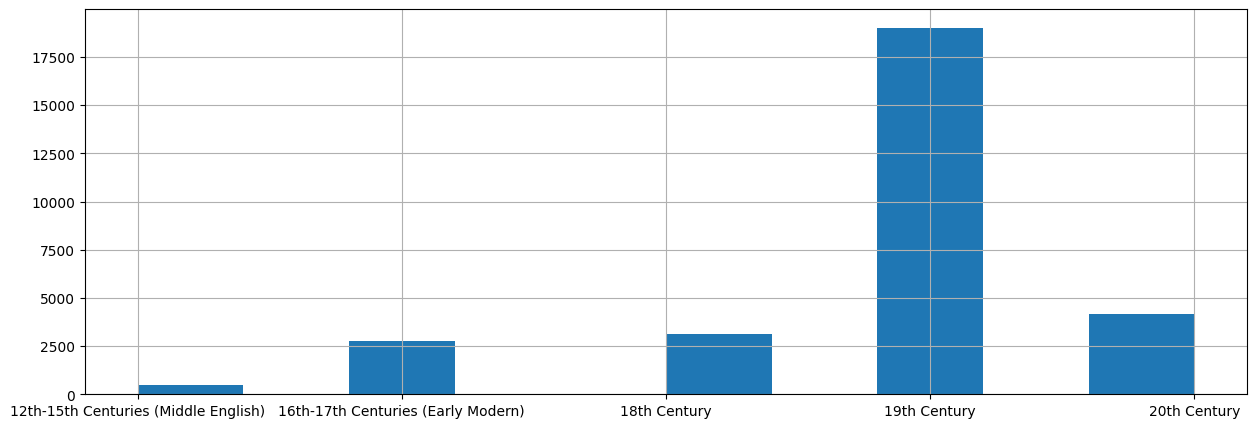

In [ ]:
# Sort values, then create a histogram, and define the size of the figure
poetry_df['period'].sort_values().hist(figsize=(15, 5))

## **Sample text dataset**

Though we wish we could analyze all the poems in this data, Colab tends to crash if we try to use more than 4-5,000 poems —  even with DistilBert, the smaller version of BERT. This is an important limitation to keep in mind. If you'd like to use more text data, you might consider upgrading to a paid version of Colab (with more memory or GPUs) or using a compute cluster.

To reduce the number of poems, we will take a random sample of 1,000 poems from four different time periods: the 20th Century, 19th Century, 18th Century, and the Early Modern period.

In [ ]:
# Filter the DataFrame for only a given time period, then randomly sample 1000 rows
nineteenth_sample = poetry_df[poetry_df['period'] == '19th Century'].sample(1000)
twentieth_sample = poetry_df[poetry_df['period'] == '20th Century'].sample(1000)
eighteenth_sample = poetry_df[poetry_df['period'] == '18th Century'].sample(1000)
sixteenth_sample = poetry_df[poetry_df['period'] == '16th-17th Centuries (Early Modern)'].sample(1000)

In [ ]:
# Merge these random samples into a new DataFrame
poetry_df = pd.concat([sixteenth_sample, eighteenth_sample, twentieth_sample, nineteenth_sample])

In [ ]:
poetry_df['period'].value_counts()

16th-17th Centuries (Early Modern)    1000
18th Century                          1000
20th Century                          1000
19th Century                          1000
Name: period, dtype: int64

Finally, let's make a list of poems from our Pandas DataFrame.

In [ ]:
poetry_texts = poetry_df['text'].tolist()

Let's examine a poem in our dataset:

In [ ]:
len(poetry_texts)

4000

In [ ]:
print(poetry_texts[0])

Ye pretty housewives, would ye know
The work that I would put ye to?
This, this it should be: for to spin
A lawn for me, so fine and thin
As it might serve me for my skin.
For cruel Love has me so whipp'd
That of my skin I all am stripp'd:
And shall despair that any art
Can ease the rawness or the smart,
Unless you skin again each part.
Which mercy if you will but do,
I call all maids to witness to
What here I promise: that no broom
Shall now or ever after come
To wrong a spinner or her loom.


## **Encode/tokenize text data for GLoVe and BERT**

In [ ]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Load GloVe model into Gensim
glove_model = KeyedVectors.load_word2vec_format(word2vec_glove_file)

def embed_sentence(sentence, model):
    # Tokenize the sentence into words
    words = word_tokenize(sentence.lower())

    # Filter out words that are not in the vocabulary
    words_in_vocab = [word for word in words if word in model]

    if not words_in_vocab:
        # If no words are in the vocabulary, return None
        return None

    # Calculate the mean of the word vectors for the words in the sentence
    sentence_vector = np.mean([model[word] for word in words_in_vocab], axis=0)

    return sentence_vector

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
sentences = poetry_texts

# Embed each sentence
for sentence in sentences:
    vector = embed_sentence(sentence, glove_model)

# If you want to save the sentence vectors for later use:
np.save("sentence_vectors.npy", np.array([embed_sentence(sentence, glove_model) for sentence in sentences]))

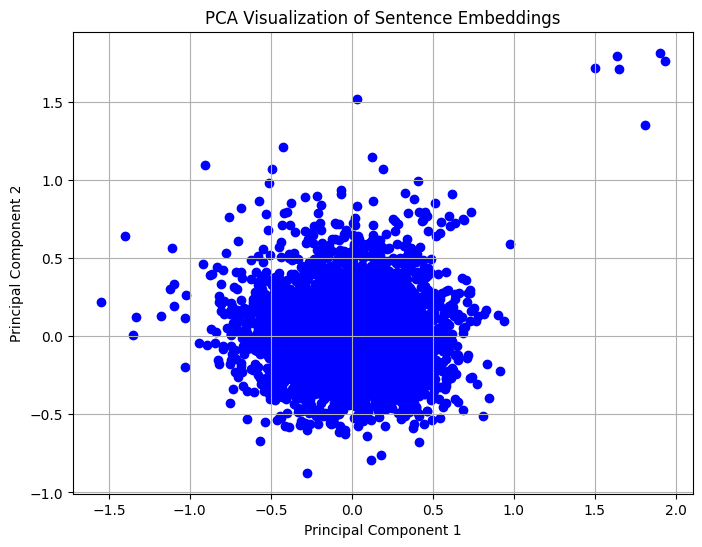

In [ ]:
import matplotlib.pyplot as plt

# Load sentence vectors (replace with your own vectors or use the saved vectors)
sentence_vectors = np.load("sentence_vectors.npy")

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(sentence_vectors)

# Plot the reduced vectors
plt.figure(figsize=(8, 6))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c='blue', marker='o')

# # Annotate points with corresponding sentences
# for i, txt in enumerate(sentences):
#     plt.annotate(txt, (reduced_vectors[i, 0], reduced_vectors[i, 1]))

plt.title('PCA Visualization of Sentence Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)

In [ ]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words is None:
        if sample > 0:
            words = np.random.choice(list(model.key_to_index.keys()), sample)
        else:
            words = [word for word in model.key_to_index]

    word_vectors = np.array([model[word] for word in words])

    twodim = PCA().fit_transform(word_vectors)[:, :2]

    plt.figure(figsize=(6, 6))
    plt.scatter(twodim[:, 0], twodim[:, 1], edgecolors='k', c='r')
    for word, (x, y) in zip(words, twodim):
        plt.text(x + 0.05, y + 0.05, word)

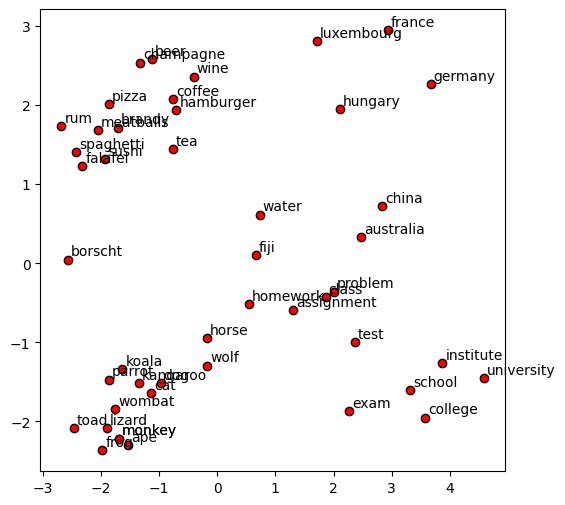

In [ ]:
display_pca_scatterplot(glove_model,
                        ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
                         'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
                         'homework', 'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 'institute'])

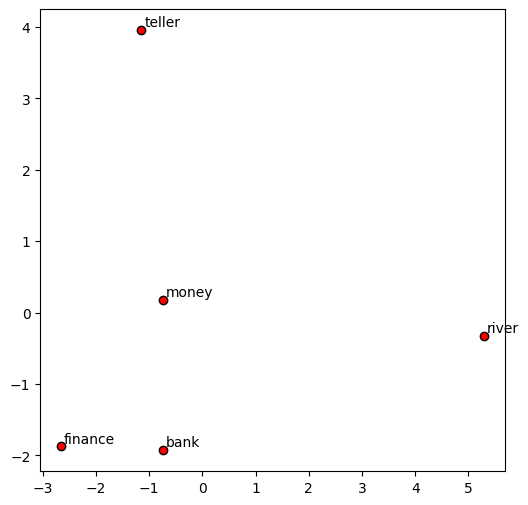

In [ ]:
display_pca_scatterplot(glove_model,
                        ['bank', 'money', 'finance', 'river', 'teller'])

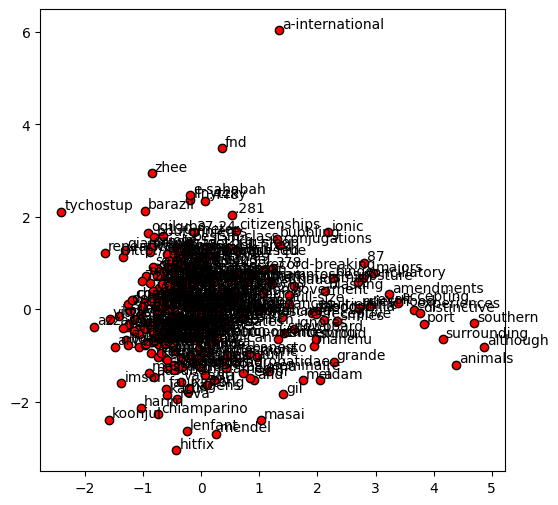

In [ ]:
# now on a random sample of words
display_pca_scatterplot(glove_model, sample = 300)

## Now, let's try with contextualized embeddings

For the contxtualized embeddings from BERT, we need to transform our poems into a format that BERT (via Huggingface) will understand. This is called *encoding* or *tokenizing* the data.

We will tokenize the poems with the `tokenizer()` from HuggingFace's `DistilBertTokenizerFast`. Here's what the `tokenizer()` will do:

1. Truncate the texts if they're more than 512 tokens or pad them if they're fewer than 512 tokens. If a word is not in BERT's vocabulary, it will be broken up into smaller "word pieces," demarcated by a `##`.

2. Add in special tokens to help BERT:
    - [CLS] — Start token of every document
    - [SEP] — Separator between each sentence
    - [PAD] — Padding at the end of the document as many times as necessary, up to 512 tokens
    - &#35;&#35; — Start of a "word piece"
    
Here we will load `DistilBertTokenizerFast` from HuggingFace library, which will help us transform and encode the texts so they can be used with BERT.

In [ ]:
from transformers import DistilBertTokenizerFast

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

The `tokenizer()` will break word tokens into word pieces, truncate to 512 tokens, and add padding and special BERT tokens.

In [ ]:
tokenized_poems = tokenizer(poetry_texts, truncation=True, padding=True, return_tensors="pt")

Let's examine the first tokenized poem. We can see that the special BERT tokens have been inserted where necessary.

In [ ]:
' '.join(tokenized_poems[0].tokens)

"[CLS] ye pretty house ##wives , would ye know the work that i would put ye to ? this , this it should be : for to spin a lawn for me , so fine and thin as it might serve me for my skin . for cruel love has me so whip ##p ' d that of my skin i all am strip ##p ' d : and shall despair that any art can ease the raw ##ness or the smart , unless you skin again each part . which mercy if you will but do , i call all maids to witness to what here i promise : that no broom shall now or ever after come to wrong a spin ##ner or her lo ##om . [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

<br><br>

## **Load pre-trained BERT model**

Here we will load a pre-trained BERT model. To speed things up we will use a GPU, but using GPU involves a few extra steps.
The command `.to("cuda")` moves data from regular memory to the GPU's memory.




In [ ]:
from transformers import DistilBertModel

In [ ]:
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to("cuda")

## **Get BERT word embeddings for each document in a collection**

To get word embeddings for all the words in our collection, we will use a `for` loop.

For each poem in our list `poetry_texts`, we will tokenize the poem, and we will extract the vocabulary word ID for each word/token in the poem (to use for later reference). Then we will run the tokenized poem through the BERT model and extract the vectors for each word/token in the poem.

We thus create two big lists for all the poems in our collection — `doc_word_ids` and `doc_word_vectors`.

In [ ]:
# List of vocabulary word IDs for all the words in each document (aka each poem)
doc_word_ids = []
# List of word vectors for all the words in each document (aka each poem)
doc_word_vectors = []

# Below we will slice our poem to ignore the first (0th) and last (-1) special BERT tokens
start_of_words = 1
end_of_words = -1

# Below we will index the 0th or first document, which will be the only document, since we're analzying one poem at a time
first_document = 0

for i, poem in enumerate(poetry_texts):

    # Here we tokenize each poem with the DistilBERT Tokenizer
    inputs = tokenizer(poem, return_tensors="pt", truncation=True, padding=True)

    # Here we extract the vocabulary word ids for all the words in the poem (the first or 0th document, since we only have one document)
    # We ignore the first and last special BERT tokens
    # We also convert from a Pytorch tensor to a numpy array
    doc_word_ids.append(inputs.input_ids[first_document].numpy()[start_of_words:end_of_words])

    # Here we send the tokenized poems to the GPU
    # The model is already on the GPU, but this poem isn't, so we send it to the GPU
    inputs.to("cuda")
    # Here we run the tokenized poem through the DistilBERT model
    outputs = model(**inputs)

    # We take every element from the first or 0th document, from the 2nd to the 2nd to last position
    # Grabbing the last layer is one way of getting token vectors. There are different ways to get vectors with different pros and cons
    doc_word_vectors.append(outputs.last_hidden_state[first_document,start_of_words:end_of_words,:].detach().cpu().numpy())


Confirm that we have the same number of documents for both the tokens and the vectors:

In [ ]:
len(doc_word_ids), len(doc_word_vectors)

(4000, 4000)

In [ ]:
doc_word_ids[0], doc_word_vectors[0]

(array([ 6300,  3492,  2160, 23744,  1010,  2052,  6300,  2113,  1996,
         2147,  2008,  1045,  2052,  2404,  6300,  2000,  1029,  2023,
         1010,  2023,  2009,  2323,  2022,  1024,  2005,  2000,  6714,
         1037, 10168,  2005,  2033,  1010,  2061,  2986,  1998,  4857,
         2004,  2009,  2453,  3710,  2033,  2005,  2026,  3096,  1012,
         2005, 10311,  2293,  2038,  2033,  2061, 11473,  2361,  1005,
         1040,  2008,  1997,  2026,  3096,  1045,  2035,  2572,  6167,
         2361,  1005,  1040,  1024,  1998,  4618, 13905,  2008,  2151,
         2396,  2064,  7496,  1996,  6315,  2791,  2030,  1996,  6047,
         1010,  4983,  2017,  3096,  2153,  2169,  2112,  1012,  2029,
         8673,  2065,  2017,  2097,  2021,  2079,  1010,  1045,  2655,
         2035, 29229,  2000,  7409,  2000,  2054,  2182,  1045,  4872,
         1024,  2008,  2053, 23528,  4618,  2085,  2030,  2412,  2044,
         2272,  2000,  3308,  1037,  6714,  3678,  2030,  2014,  8840,
      

## **Concatenate all word IDs/vectors for all documents**

Each element of these lists contains all the tokens/vectors for one document. But we want to concatenate them into two giant collections.

In [ ]:
all_word_ids = np.concatenate(doc_word_ids)
all_word_vectors = np.concatenate(doc_word_vectors, axis=0)

We want to make comparisons between vectors quickly. One common option is *cosine similarity*, which measures the angle between vectors but ignores their length. We can speed this computation up by setting all the poem vectors to have length 1.0.

In [ ]:
# Calculating the length of each vector (Pythagorean theorem)
row_norms = np.sqrt(np.sum(all_word_vectors ** 2, axis=1))
# Dividing every vector by its length
all_word_vectors /= row_norms[:,np.newaxis]

## **Find all word positions in a collection**

We can use the array `all_word_ids` to find all the places, or *positions*, in the collection where a word appears.

We can find a word's vocab ID in BERT with `tokenizer.vocab` and then check to see where/how many times this ID occurs in `all_word_ids`.

In [ ]:
def get_word_positions(words):

  """This function accepts a list of words, rather than a single word"""

  # Get word/vocabulary ID from BERT for each word
  word_ids = [tokenizer.vocab[word] for word in words]

  # Find all the positions where the words occur in the collection
  word_positions = np.where(np.isin(all_word_ids, word_ids))[0]

  return word_positions

Here we'll check to see all the places where the word "bank" appears in the collection.

In [ ]:
get_word_positions(["bank"])

array([ 91965, 106616, 116233, 122109, 131708, 137554, 173944, 201471,
       270834, 279768, 294010, 294147, 336914, 351609, 356081, 356083,
       357318, 373263, 374121, 374985, 385262, 390506, 458540, 460492,
       501562, 521167, 523052, 530254, 633071, 697274, 740661, 751812,
       769406, 779989, 819168, 832665, 845311])

In [ ]:
word_positions = get_word_positions(["bank"])

## **Find word from word position**

Nice! Now we know all the positions where the word "bank" appears in the collection. But it would be more helpful to know the actual words that appear in context around it. To find these context words, we have to convert position IDs back into words.

In [ ]:
# Here we create an array so that we can go backwards from numeric token IDs to words
word_lookup = np.empty(tokenizer.vocab_size, dtype="O")

for word, index in tokenizer.vocab.items():
    word_lookup[index] = word

Now we can use `word_lookup` to find a word based on its position in the collection.

In [ ]:
word_positions = get_word_positions(["bank"])

for word_position in word_positions:
  print(word_position, word_lookup[all_word_ids[word_position]])

91965 bank
106616 bank
116233 bank
122109 bank
131708 bank
137554 bank
173944 bank
201471 bank
270834 bank
279768 bank
294010 bank
294147 bank
336914 bank
351609 bank
356081 bank
356083 bank
357318 bank
373263 bank
374121 bank
374985 bank
385262 bank
390506 bank
458540 bank
460492 bank
501562 bank
521167 bank
523052 bank
530254 bank
633071 bank
697274 bank
740661 bank
751812 bank
769406 bank
779989 bank
819168 bank
832665 bank
845311 bank


We can also look for the 3 words that come before "bank" and the 3 words that come after it.

In [ ]:
word_positions = get_word_positions(["bank"])

for word_position in word_positions:

  # Slice 3 words before "bank"
  start_pos = word_position - 3
  # Slice 3 words after "bank"
  end_pos = word_position + 4

  context_words = word_lookup[all_word_ids[start_pos:end_pos]]
  # Join the words together
  context_words = ' '.join(context_words)
  print(word_position, context_words)

91965 sent , the bank ##es to weep
106616 sober stream , bank ' d all
116233 ##tty * * bank , the which
122109 a sunni ##e bank ##e outstretched lay
131708 then on the bank of jordan ,
137554 by , this bank ##e with roses
173944 to the warm bank below , yellow
201471 the dew ##y bank to grace !
270834 leaving on the bank his spear against
279768 on the green bank of clear al
294010 on a summer bank , to sing
294147 bends on the bank , amid the
336914 sunshine on the bank : no tear
351609 residence at allan bank . the long
356081 , shooting from bank to bank ,
356083 from bank to bank , now in
357318 pool ; this bank abrupt and high
373263 , on some bank beside a river
374121 lily by the bank , the pri
374985 er yo ##n bank and o '
385262 the gravel ##ly bank thrown up by
390506 ! from what bank came those live
458540 the river - bank is one bright
460492 clay of its bank , the barge
501562 ##nation of a bank we couldn '
521167 the great north bank to the car
523052 , come ##ly bank and

Let's make some functions that will help us get the context words around a certain word position for whatever size window (certain number of words before and after) that we want.

The first function `get_context()` will simply return the tokens without cleaning them, and the second function `get_context_clean()` will return the tokens in a more readable fashion.

In [ ]:
def get_context(word_id, window_size=10):

  """Simply get the tokens that occur before and after word position"""

  start_pos = max(0, word_id - window_size) # The token where we will start the context view
  end_pos = min(word_id + window_size + 1, len(all_word_ids)) # The token where we will end the context view

  # Make a list called tokens and use word_lookup to get the words for given token IDs from starting position up to the keyword
  tokens = [word_lookup[word] for word in all_word_ids[start_pos:end_pos] ]

  context_words = " ".join(tokens)

  return context_words

In [ ]:
import re

def get_context_clean(word_id, window_size=10):

  """Get the tokens that occur before and after word position AND make them more readable"""

  keyword = word_lookup[all_word_ids[word_id]]
  start_pos = max(0, word_id - window_size) # The token where we will start the context view
  end_pos = min(word_id + window_size + 1, len(all_word_ids)) # The token where we will end the context view

  # Make a list called tokens and use word_lookup to get the words for given token IDs from starting position up to the keyword
  tokens = [word_lookup[word] for word in all_word_ids[start_pos:end_pos] ]

  # Make wordpieces slightly more readable
  # This is probably not the most efficient way to clean and correct for weird spacing
  context_words = " ".join(tokens)
  context_words = re.sub(r'\s+([##])', r'\1', context_words)
  context_words = re.sub(r'##', r'', context_words)
  context_words = re.sub('\s+\'s', '\'s', context_words)
  context_words = re.sub('\s+\'d', '\'d', context_words)
  context_words = re.sub('\s\'er', '\'er', context_words)
  context_words = re.sub(r'\s+([-,:?.!;])', r'\1', context_words)
  context_words = re.sub(r'([-\'"])\s+', r'\1', context_words)
  context_words = re.sub('\s+\'s', '\'s', context_words)
  context_words = re.sub('\s+\'d', '\'d', context_words)

  # Bold the keyword by putting asterisks around it
  if keyword in context_words:
    context_words = re.sub(f"\\b{keyword}\\b", f"**{keyword}**", context_words)
    context_words = re.sub(f"\\b({keyword}[esdtrlying]+)\\b", fr"**\1**", context_words)

  return context_words

To visualize the search keyword even more easily, we're going to import a couple of Python modules that will allow us to output text with bolded words and other styling. Here we will make a function `print_md()` that will allow us to print with Markdown styling.

In [ ]:
from IPython.display import Markdown, display

def print_md(string):
    display(Markdown(string))

In [ ]:
word_positions = get_word_positions(["bank"])

for word_position in word_positions:

  print_md(f"<br> {word_position}:  {get_context_clean(word_position)} <br>")

<br> 91965:  threw, such sounds yet forth it sent, the **bankes** to weepe that drue, as down <br>

<br> 106616:  to flow, like to a solemn sober stream, **bank**'d all with lilies, and the cream <br>

<br> 116233:  silver streaming themmes; whose rutty * * **bank**, the which his river hemmes, was pay <br>

<br> 122109:  shore of muddie nile, upon a sunnie **banke** outstretched lay, in monstrous length, a might <br>

<br> 131708:  but return'd in vain. then on the **bank** of jordan, by a creek: where winds with <br>

<br> 137554:  , all our flocks are feeding by, this **banke** with roses spred, oh it is a <br>

<br> 173944:  ample numbers stray. ii. then to the warm **bank** below, yellow with the morning-ray, and <br>

<br> 201471:  his small green lamp at night, the dewy **bank** to grace! it is a glow-worm, <br>

<br> 270834:  course he, chief of heroes, leaving on the **bank** his spear against a tamarisk reclined, <br>

<br> 279768:  , 'mid the circling wood, on the green **bank** of clear alb [ = u ] nea <br>

<br> 294010:  green abode, and, seated on a summer **bank**, to sing no earthly music; in a spot <br>

<br> 294147:  ; from where the pensile birch bends on the **bank**, amid the clustered group of the dark hollie <br>

<br> 336914:  the tree, the wood, the sunshine on the **bank**: no tear, no thought of time's <br>

<br> 351609:  grasmere, chiefly during our residence at allan **bank**. the long poem on my own education was, <br>

<br> 356081:  still water, with his dragon wings, shooting from **bank** to **bank**, now in quick turns, then swift <br>

<br> 356083:  , with his dragon wings, shooting from **bank** to **bank**, now in quick turns, then swift athwa <br>

<br> 357318:  zy-running brook forms a deep pool; this **bank** abrupt and high, and that fair-spreading in <br>

<br> 373263:  , and in our mossy valleys, on some **bank** beside a river clear, throw thy silk draperies <br>

<br> 374121:  t. iii. now blooms the lily by the **bank**, the primrose down the brae; <br>

<br> 374985:  dearie. ii. o 'er yon **bank** and o 'er yon brae, o <br>

<br> 385262:  washed by the sea, or on the gravelly **bank** thrown up by wintry torrents roaring loud, <br>

<br> 390506:  proof, though christian rites be wanting! from what **bank** came those live herbs? by what hand were they <br>

<br> 458540:  he sees life spilt. the river-**bank** is one bright crazy-quilt of patch-work <br>

<br> 460492:  belliferous flowers, and the yellow clay of its **bank**, the barge's brown sails that are fur <br>

<br> 501562:  for the law; the stagnation of a **bank** we couldn 't stand; for our riot blood <br>

<br> 521167:  the gap below the plank ) from the great north **bank** to the caribbees ( down by the <br>

<br> 523052:  . there's barbara cowie, comely **bank** and may, christened, at home, in <br>

<br> 530254:  and bats, and mocked by hopeless longing to regain **bank**-holidays, and picture shows, and spats <br>

<br> 633071:  mists that cloak hanger and hollied **bank**, the winter world awoke to hear the feeble <br>

<br> 697274:  way; and where we drank, the puddled **bank** is crisping into clay. the traitor dark gives <br>

<br> 740661:  better than **banking**, trade or leases, take a **bank** note and fold it up, and then you will <br>

<br> 751812:  their memory-hallowed acres. their gardens, **banked** with roses and with lilies-those sweet <br>

<br> 769406:  . it was a stream of living beams, whose **bank** on either side by the cloud's cleft <br>

<br> 779989:  i will linger where the gale o 'er the **bank** of violets sighs, listening to hear its soft <br>

<br> 819168:  leave those wreaths to wither upon the cold **bank** there; and tell her thus, when youth is <br>

<br> 832665:  , complain thou not, o heart; for these **bank**-in the current of the will to uses, <br>

<br> 845311:  while haply, not far off, beneath a **bank** of blossoming acacias, many a prank is <br>

Here we make a list of all the context views for our keyword.

In [ ]:
word_positions = get_word_positions(["bank"])

keyword_contexts = []
keyword_contexts_tokens = []

for position in word_positions:

  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

## **Get word vectors and reduce them with PCA**

Finally, we don't just want to *read* all the instances of "bank" in the collection, we want to *measure* the similarity of all the instances of "bank."

To measure similarity between all the instances of "bank," we will take the vectors for each instance and then use PCA to reduce each 768-dimensionsal vector to the 2 dimensions that capture the most variation.

In [ ]:
word_positions = get_word_positions(["bank"])

pca = PCA(n_components=2)

pca.fit(all_word_vectors[word_positions,:].T)

PCA(n_components=2)

Then, for convenience, we will put these PCA results into a Pandas DataFrame, which will use to generate an interactive plot.

In [ ]:
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens})
df.head()

,x,y,context,tokens
0,-0.156258,-0.292509,"threw, such sounds yet forth it sent, the **bankes** to weepe that drue, as down","threw , such sounds yet forth it sent , the bank ##es to weep ##e that dr ##ue , as down"
1,-0.153589,-0.273092,"to flow, like to a solemn sober stream, **bank**'d all with lilies, and the cream","to flow , like to a solemn sober stream , bank ' d all with lil ##ies , and the cream"
2,-0.171403,-0.062208,"silver streaming themmes; whose rutty * * **bank**, the which his river hemmes, was pay","silver streaming them ##mes ; whose ru ##tty * * bank , the which his river hem ##mes , was pay"
3,-0.165074,-0.207605,"shore of muddie nile, upon a sunnie **banke** outstretched lay, in monstrous length, a might","shore of mud ##die nile , upon a sunni ##e bank ##e outstretched lay , in monstrous length , a might"
4,-0.166978,0.222695,"but return'd in vain. then on the **bank** of jordan, by a creek: where winds with","but return ' d in vain . then on the bank of jordan , by a creek : where winds with"


## **Match context with original text and metadata**

It's helpful (and fun!) to know where each instance of a word actually comes from — which poem, which poet, which time period, which Public-Domain-Poetry.com web page. The easiest method we've found for matching a bit of context with its original poem and metdata is to 1) add a tokenized version of each poem to our original Pandas Dataframe 2) check to see if the context shows up in a poem 3) and if so, grab the original poem and metadata.

In [ ]:
# Tokenize all the poems
tokenized_poems = tokenizer(poetry_texts, truncation=True, padding=True, return_tensors="pt")

# Get a list of all the tokens for each poem
all_tokenized_poems = []
for i in range(len(tokenized_poems['input_ids'])):
  all_tokenized_poems.append(' '.join(tokenized_poems[i].tokens))

# Add them to the original DataFrame
poetry_df['tokens'] = all_tokenized_poems

In [ ]:
poetry_df.head(2)

,author,title,text,lifespan,birth_year,death_year,link,period,tokens
21170,Robert Herrick,To The Little Spinners,"Ye pretty housewives, would ye know\r\nThe work that I would put ye to?\r\nThis, this it should be: for to spin\r\nA lawn for me, so fine and thin\r\nAs it might serve me for my skin.\r\nFor cruel...","Baptized - August 24, 1591- October 1674",1591.0,1674.0,http://public-domain-poetry.com/robert-herrick/to-the-little-spinners-18863,16th-17th Centuries (Early Modern),"[CLS] ye pretty house ##wives , would ye know the work that i would put ye to ? this , this it should be : for to spin a lawn for me , so fine and thin as it might serve me for my skin . for cruel..."
13640,John Milton,On His Blindness,"When I consider how my light is spent\r\nEre half my days in this dark world and wide,\r\nAnd that one talent which is death to hide\r\nLodg'd with me useless, though my soul more bent\r\nTo serve...","December 9, 1608-November 8, 1674",1608.0,1674.0,http://public-domain-poetry.com/john-milton/on-his-blindness-8424,16th-17th Centuries (Early Modern),"[CLS] when i consider how my light is spent er ##e half my days in this dark world and wide , and that one talent which is death to hide lo ##d ##g ' d with me useless , though my soul more bent t..."


In [ ]:
def find_original_poem(rows):

  """This function checks to see whether the context tokens show up in the original poem,
  and if so, returns metadata about the title, author, period, and URL for that poem"""

  text = rows['tokens'].replace('**', '')
  text = text[55:70]

  if poetry_df['tokens'].str.contains(text, regex=False).any() == True :
    row = poetry_df[poetry_df['tokens'].str.contains(text, regex=False)].values[0]
    title, author, period, link = row[0], row[1], row[7], row[6]
    return author, title, period, link
  else:
    return None, None, None, None

In [ ]:
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

In [ ]:
df

,x,y,context,tokens,title,author,period,link
0,-0.156258,-0.292509,"threw, such sounds yet forth it sent, the **bankes** to weepe that drue, as down","threw , such sounds yet forth it sent , the bank ##es to weep ##e that dr ##ue , as down",To Himselfe And The Harpe,Michael Drayton,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/michael-drayton/to-himselfe-and-the-harpe-14544
1,-0.153589,-0.273092,"to flow, like to a solemn sober stream, **bank**'d all with lilies, and the cream","to flow , like to a solemn sober stream , bank ' d all with lil ##ies , and the cream","An Eclogue Or Pastoral Between Endymion Porter And Lycidas Herrick, Set And Sung",Robert Herrick,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/robert-herrick/an-eclogue-or-pastoral-between-endymion-porter-and-lycidas-herrick-set-and-sung-18895
2,-0.171403,-0.062208,"silver streaming themmes; whose rutty * * **bank**, the which his river hemmes, was pay","silver streaming them ##mes ; whose ru ##tty * * bank , the which his river hem ##mes , was pay","Prothalamion: Or, A Spousall Verse",Edmund Spenser,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/edmund-spenser/prothalamion-or-a-spousall-verse-32239
3,-0.165074,-0.207605,"shore of muddie nile, upon a sunnie **banke** outstretched lay, in monstrous length, a might","shore of mud ##die nile , upon a sunni ##e bank ##e outstretched lay , in monstrous length , a might",Visions Of The Worlds Vanitie,Edmund Spenser,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/edmund-spenser/visions-of-the-worlds-vanitie-32234
4,-0.166978,0.222695,"but return'd in vain. then on the **bank** of jordan, by a creek: where winds with","but return ' d in vain . then on the bank of jordan , by a creek : where winds with",Paradise Regained - The Second Book,John Milton,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/john-milton/paradise-regained-the-second-book-8323
5,-0.158862,-0.279697,", all our flocks are feeding by, this **banke** with roses spred, oh it is a",", all our flock ##s are feeding by , this bank ##e with roses sp ##red , oh it is a",From England's Helicon,Michael Drayton,16th-17th Centuries (Early Modern),http://public-domain-poetry.com/michael-drayton/from-englands-helicon-14591
6,-0.174111,0.168458,"ample numbers stray. ii. then to the warm **bank** below, yellow with the morning-ray, and","ample numbers stray . ii . then to the warm bank below , yellow with the morning - ray , and","Odes From Horace. - [1]On The Pleasures Of Rural Life. Book The Fifth, Epode The Second",Anna Seward,18th Century,http://public-domain-poetry.com/anna-seward/odes-from-horace-1on-the-pleasures-of-rural-life-book-the-fifth-epode-the-second-31214
7,-0.171105,-0.111371,"his small green lamp at night, the dewy **bank** to grace! it is a glow-worm,","his small green lamp at night , the dew ##y bank to grace ! it is a glow - worm ,",The Glow-Worm. (From The Villager's Verse-Book.),William Lisle Bowles,18th Century,http://public-domain-poetry.com/william-lisle-bowles/glow-worm-from-the-villagers-verse-book-35386
8,-0.168901,0.180845,"course he, chief of heroes, leaving on the **bank** his spear against a tamarisk reclined,","course he , chief of heroes , leaving on the bank his spear against a tam ##aris ##k rec ##lined ,",The Iliad Of Homer: Translated Into English Blank Verse: Book XXI,William Cowper,18th Century,http://public-domain-poetry.com/william-cowper/iliad-of-homer-translated-into-english-blank-verse-book-xxi-13077
9,-0.170824,0.155342,", 'mid the circling wood, on the green **bank** of clear alb [ = u ] nea",", ' mid the circling wood , on the green bank of clear al ##b [ = u ] ne ##a","Odes From Horace. - To [1]Munatius Plancus. Book The First, Ode The Seventh",Anna Seward,18th Century,http://public-domain-poetry.com/anna-seward/odes-from-horace-to-1munatius-plancus-book-the-first-ode-the-seventh-31193


## **Plot word embeddings**

Lastly, we will plot the words vectors from this DataFrame with the Python data viz library [Altair](https://altair-viz.github.io/gallery/scatter_tooltips.html).

In [ ]:
import altair as alt

In [ ]:
alt.Chart(df,title="Word Similarity: Bank").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    # If you click a point, take you to the URL link
    href="link",
    # The categories that show up in the hover tooltip
    tooltip=['title', 'context', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

## **Plot word embeddings from keywords (all at once!)**

We can put the code from the previous few sections into a single cell and plot the BERT word embeddings for any list of words. Let's look at the words "nature," "religion," "science," and "art."

In [ ]:
# List of keywords that you want to compare
keywords = ['nature', 'religion', 'science', 'art']

# How to color the points in the plot. The other option is "period" for time period
color_by = 'word'

# Get all word positions
word_positions = get_word_positions(keywords)

# Get all contexts around the words
keyword_contexts = []
keyword_contexts_tokens = []
words = []

for position in word_positions:
  words.append(word_lookup[all_word_ids[position]])
  keyword_contexts.append(get_context_clean(position))
  keyword_contexts_tokens.append(get_context(position))

# Reduce word vectors with PCA
pca = PCA(n_components=2)
pca.fit(all_word_vectors[word_positions,:].T)

# Make a DataFrame with PCA results
df = pd.DataFrame({"x": pca.components_[0,:], "y": pca.components_[1,:],
                   "context": keyword_contexts, "tokens": keyword_contexts_tokens, "word": words})
# Match original text and metadata
df[['title', 'author', 'period', 'link']] = df.apply(find_original_poem, axis='columns', result_type='expand')

# Rename columns so that the context shows up as the "title" in the tooltip (bigger and bolded)
df = df.rename(columns={'title': 'poem_title', 'context': 'title'})

# Make the plot
alt.Chart(df, title=f"Word Similarity: {', '.join(keywords).title()}").mark_circle(size=200).encode(
    alt.X('x',
        scale=alt.Scale(zero=False)
    ), y="y",
    color= color_by,
    href="link",
    tooltip=['title', 'word', 'poem_title', 'author', 'period']
    ).interactive().properties(
    width=500,
    height=500
)

alt.Chart(...)

## Try by yourself: Train an SVM model with the word embeddings as your representation

Get embeddings for your documents, but instead of a Bag-of-words representation we used last time, train a model with word embedding representations of your documents. You can reuse the poetry dataset. Try to detect which time period a piece of poetry was written in. Try two types of representations:

1. Static embeddings from GLoVe
2. Contextualized embeddings from DistilBERT
